# Simple example of a neural network classifier

I've put a bunch of code below that:
1.   Loads the MNIST dataset of images handwritten digits (0-9)
2.   Filters out two digits for classification
3.   Converts the labels to zeros and ones
4.   Plots some examples of the images we'll classify
5.   Defines the Neural Network class, MLP = MultiLayer Perceptron
6.   Prepares a dataloader to feed data to the NN during training
7.   Trains the neural network
8.   Evaluates and plots the performance.

I used ChatGPT to generate code to get started, then made changes to it and I'll explain wht each part does below.



We need the torch and torchvision packages, which we can install using pip from the Jupyter notebook using the ! symbol.

In [1]:
!pip install torch torchvision

Importing everything we need...

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

The code below essentially gets the dataset and makes sure the labels are correct, I've added comments to explain what's going on.

In [21]:
# this is a transform which we will use to convert the dataset that we get into a pytorch tensor,
# which is the data type used in the neural network.
# the transforms code comes from torchvision, you can see from the imports
# torchvision is a package used alongside pytorch for training neural networks
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST training and test datasets
# torchvision comes with a datasets package that lets us download different commonly used datasets
# we use that below, using our transform function to convert it to a pytorch tensor
# we get train and test data separately, because we need data that the network has not seen during training to properly test it
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter the dataset for digits 8 and 9 only
# the dataset we download is a bunch of images of digits from 0-9,
# we only want two of them, this function extracts the digits we want
# idx just needs to be a list of digits we want
def filter_digits(dataset, digits):
    idx = np.isin(dataset.targets, digits)
    dataset.targets = dataset.targets[idx]
    dataset.data = dataset.data[idx]
    return dataset

# use the above function to extract digits 8 and 9
mnist_train = filter_digits(mnist_train, [8, 9])
mnist_test = filter_digits(mnist_test, [8, 9])

# the dataset sets the labels to the truth value of the digit, i.e. 8 and 9
# with a NN it's usually standard to use labels 0 adn 1
# so we define a function to convert labels: 8 -> 0 (negative class), 9 -> 1 (positive class)
def convert_labels(dataset):
    dataset.targets = torch.where(dataset.targets == 8, 0, 1)  # 1 -> 0, 9 -> 1
    return dataset

# and we use the function to define our train and test set
mnist_train = convert_labels(mnist_train)
mnist_test = convert_labels(mnist_test)

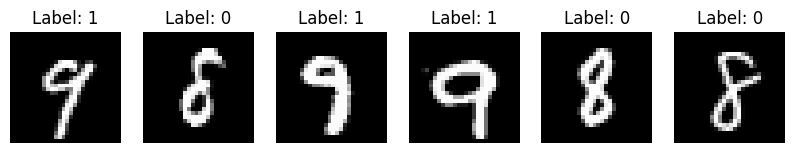

In [22]:
# Plot some samples of the dataset (digit 1 and 9)
def plot_samples(data, targets):
    fig, axes = plt.subplots(1, 6, figsize=(10, 4))
    for i in range(6):
        idx = torch.randint(0, len(data), size=(1,)).item()
        axes[i].imshow(data[idx], cmap='gray')
        axes[i].set_title(f'Label: {targets[idx].item()}')
        axes[i].axis('off')
    plt.show()

plot_samples(mnist_train.data, mnist_train.targets)

In [26]:
# here we define the neural network
# the images are all images, 28 by 28 pixels each
# to put this in the network we flatten it to a vector of size 28*28
# in the MLP class below, when an MLP is initialised we define the 'layers' of the network
# the first layer must accept a vector of size 28*28, i.e. the whole image
# we can have as many layers as we want as long as:
#    1 - the last layer has an output of dimension 1
#    2 - in the intermediate (hidden) layers, the output dimension of the last must equal the input dimension of the next
#        this is so that the data being passed through the network has the correct size (matrix multiplication)
# at the very end we then have a sigmoid layer, this just converts the 1 dimensional output of the last layer to a number between 0 and 1
# the class then needs to have a 'forward' method, this is what is called when we pass data through a network
# it takes in a vector x (in this case it has dimension 28*28)
# and passes it sequentially through each layer of the network, and returns the final value
# in the MLP class below I started with a network with three layers:
#    1 - the input layer fc1
#    2 - a hidden layer fc2
#    3 - the output layer fc3
# but I commented out some code and changed the output dimension of fc1 to 1 (instead of 32)
# to convert it to a single layer network, it's just for testing.
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1)
        #self.fc2 = nn.Linear(32, 16)
        #self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        #x = torch.relu(self.fc2(x))
        #x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [27]:
# dataloaders are just a handy way to feed data to a neural network
# we can also use more complicated for loops and index the data ourselves
# but this built-in functionality from pytorch is pretty handy
# the network training works by:
#    1 - pass one part of your training data (a batch) through the network
#    2 - compute the loss
#    3 - compute the gradients
#    4 - update the neural network weights using the gradients
#        this moves the network closer to a configuration where the overall loss computed with the data is smaller
#        this is monimising the loss
# so below we first define the batch_size, the number of images in each batch
# the dataloader is then defined to feed the network this number of images each time
batch_size = 64
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# below we just check if there is a GPU available on the machine
# if there is then we use it, if not we use the CPU
# an important feature of pytroch is that data being used always needs to be moved to whatever device is using it
# note that every time we instantiate the model below using `model = MLP()`, the weights are reset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)

# below we define two things:
#    1 - the criterion, or the loss function
#        this is what we minimise, we take the output of the neural network, a single number x,
#        along with the truth labels, and put them into this mathematical function
#        it is chosen so that the smaller it is, the closer the network outputs for each image are to the truth labels
#    2 - the optimiser
#        this is just an algorithm that decides how to update the weights of the network given the gradients that we get from the loss
#        no need to worry about this yet, Adam is a very standard choice
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# below is a training loop for the model
# a single epoch is a complete pass through of the whole training dataset
# e.g. if there are 1000 batches in our training dataset, the weights would be updated 1000 times
# we set num_epochs to 5 here, so that we go through the whole dataset 5 times
num_epochs = 5
for epoch in range(num_epochs): # loops over each epoch
    model.train()               # this puts the MLP model in training mode, and auto-calculates the gradients
    running_loss = 0.0          # we want to track how the loss changes as we go
    y_true_epoch = []           # we also want to track the performance
    y_scores_epoch = []         # ""
    for images, labels in train_loader:       # loop over each image in the batch
        images, labels = images.to(device), labels.to(device).float()   # puts them on the device and ensures correct type

        # Forward pass
        outputs = model(images).squeeze()     # the images are passed through the network to get an output for each image in the batch
        loss = criterion(outputs, labels)     # calculate the loss for each image in the batch

        # Backward pass and optimization
        optimizer.zero_grad()                 # before updating the weights we reset the optimizer, important!
        loss.backward()                       # calculate the gradients from the loss
        optimizer.step()                      # we update the weights in the network using the optimizer

        running_loss += loss.item()           # we update the running_loss to track it after each batch

        # Collect true labels and model probabilities (outputs)
        y_true_epoch.extend(labels.cpu().numpy())               #we're tracking the predicted labels after each batch
        y_scores_epoch.extend(outputs.detach().cpu().numpy())

    # Compute AUC for the epoch
    auc_epoch = roc_auc_score(y_true_epoch, y_scores_epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, AUC: {auc_epoch:.4f}')

Epoch [1/5], Loss: 0.4850, AUC: 0.9446
Epoch [2/5], Loss: 0.4067, AUC: 0.9890
Epoch [3/5], Loss: 0.3920, AUC: 0.9897
Epoch [4/5], Loss: 0.3846, AUC: 0.9897
Epoch [5/5], Loss: 0.3801, AUC: 0.9905


<ipython-input-28-9a35ea167b0f>:24: RuntimeWarning: divide by zero encountered in divide
  inv_fpr = np.where(fpr == 0, np.nan, 1 / fpr)  # 1 / FPR, but set FPR = 0 to NaN


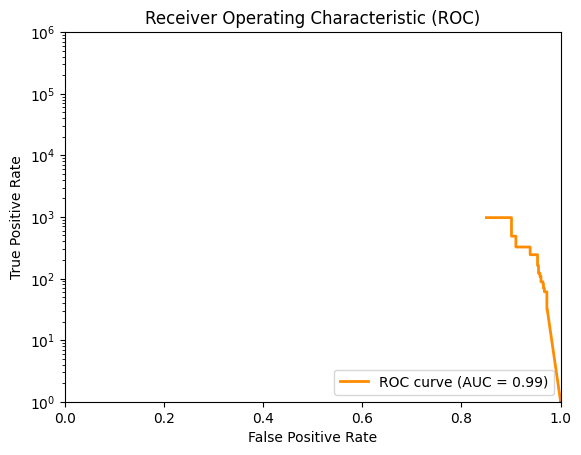

In [28]:
# here we compute the ROC curve, that is the TPR and FPR
# and we plot TPR vs 1/FPR
# these plots are common in particle physics, but in standard ML applications people usually plot FPT vs TPR
# we also calculate the AUC again at the end
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze().cpu().numpy()
        y_scores.extend(outputs)
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 6. Plot ROC curve
inv_fpr = np.where(fpr == 0, np.nan, 1 / fpr)  # 1 / FPR, but set FPR = 0 to NaN
inv_fpr = np.nan_to_num(inv_fpr, nan=np.inf)   # Replace NaNs with inf for plotting
plt.figure()
plt.yscale('log')
plt.plot(tpr, inv_fpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1.0, 10e5])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()